In [2]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## Downscaling for IMERG 3h in Veneto region

In [18]:
name, yy_s, yy_e = 'Coast Level', 2001, 2016
# name, yy_s, yy_e = 'Low Level', 2001, 2013
# name, yy_s, yy_e = 'Medium Level', 2001, 2016
# name, yy_s, yy_e = 'High Level', 2001, 2022

print(f'Station   : {name}')
print(f'Start year: {yy_s}')
print(f'End year  : {yy_e}')

Station   : Coast Level
Start year: 2001
End year  : 2016


In [19]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

In [20]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [83]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 449MB
Dimensions:  (time: 46752, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 374kB 2001-01-01 ... 2016-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [40]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

In [115]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Coast Level station


,dataora,valore,qualita,yy,mm,dd,hh
528403,2017-11-30 10:00:00,0.0,1.0,2017,0,30,10
528404,2017-11-30 10:30:00,0.0,1.0,2017,30,30,10
528405,2017-11-30 11:00:00,0.0,1.0,2017,0,30,11


In [116]:
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN.set_index('dataora', inplace=True)

In [117]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
rainfall_3h_accumulated = CL_RAIN['valore'].resample('3H').sum()
OBS_3h = pd.DataFrame({'PRE':rainfall_3h_accumulated.values, 'TIME':pd.to_datetime(rainfall_3h_accumulated.index)})

In [120]:
# Fit weibull for daily OBS time
OBS = xr.DataArray(OBS_3h['PRE'].values,  coords={'time':OBS_3h['TIME'].values}, dims=('time'))
NCW, YEARS = down.fit_yearly_weibull(OBS, thresh=1, maxmiss=36)

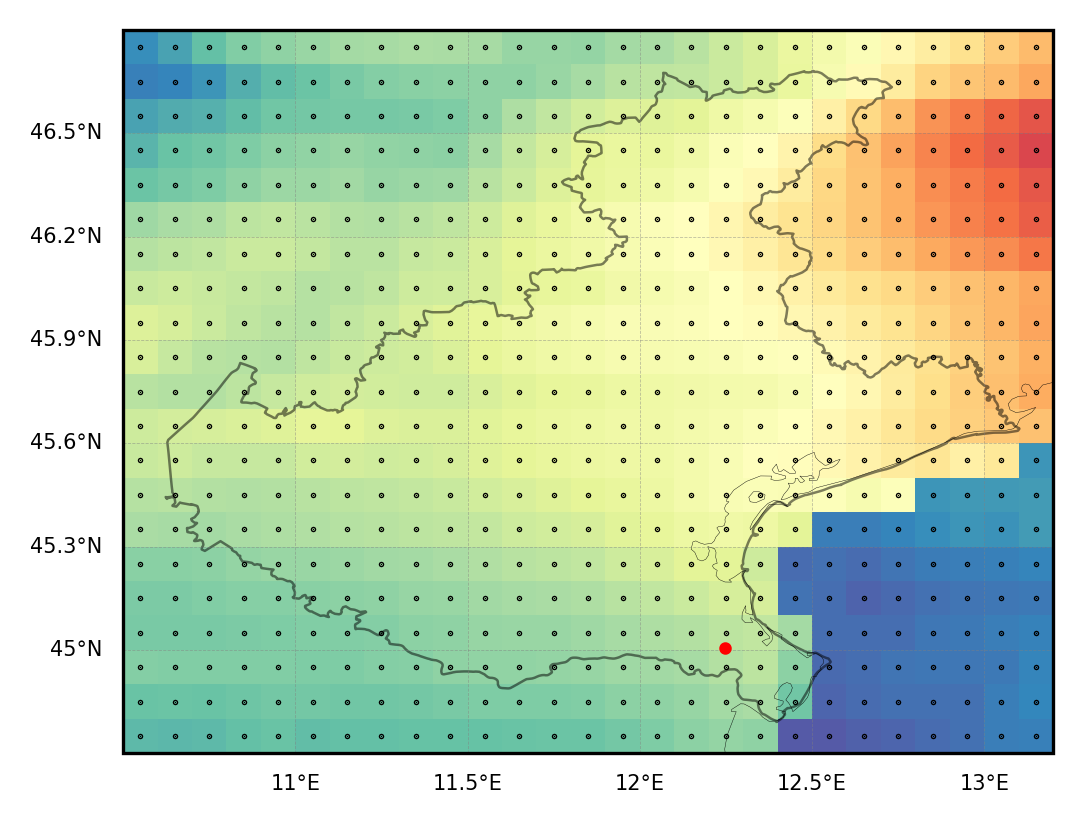

In [45]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')

ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=4, c='r', zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [54]:
RAIN_lat = CL_INFO['Lat'].values[0]
RAIN_lon = CL_INFO['Lon'].values[0]

In [63]:
distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

IMERG_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 45.04999923706055
Station lat       : 45.00466666

Nearest IMERG lon: 12.25
Station lon       : 12.24819444


In [64]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3

Tr = np.array([5, 10, 20, 50, 80, 100])
Fi = 1-1/Tr
nyears = len(Tr)

npix = 3
buffer = 0.5*npix*dx

In [74]:
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':DATES.data}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [75]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [76]:
box_3h = xrs.where(bcond, drop = True).load()
box_3h = box_3h.resample(time ='D').sum(dim='time', skipna=False)
box_3h.shape

(3, 3, 5844)

In [77]:
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=100, clat=clat, clon=clon,
                            opt_method='genetic', plot=True) #maxmiss=36

Downscaling Intermittency
Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.00038837793884717044
differential_evolution step 2: f(x)= 0.00037762691021183526
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


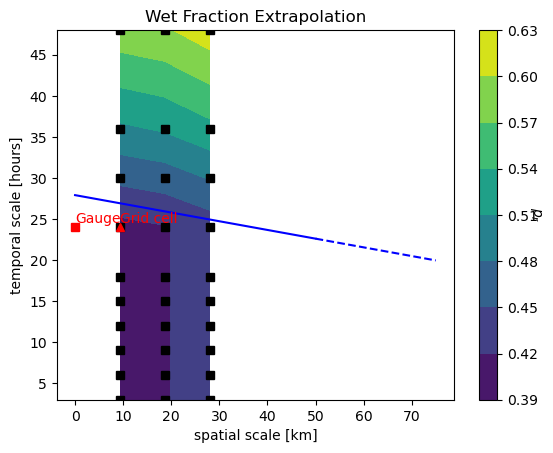

In [123]:
downres['Taylor_contour']

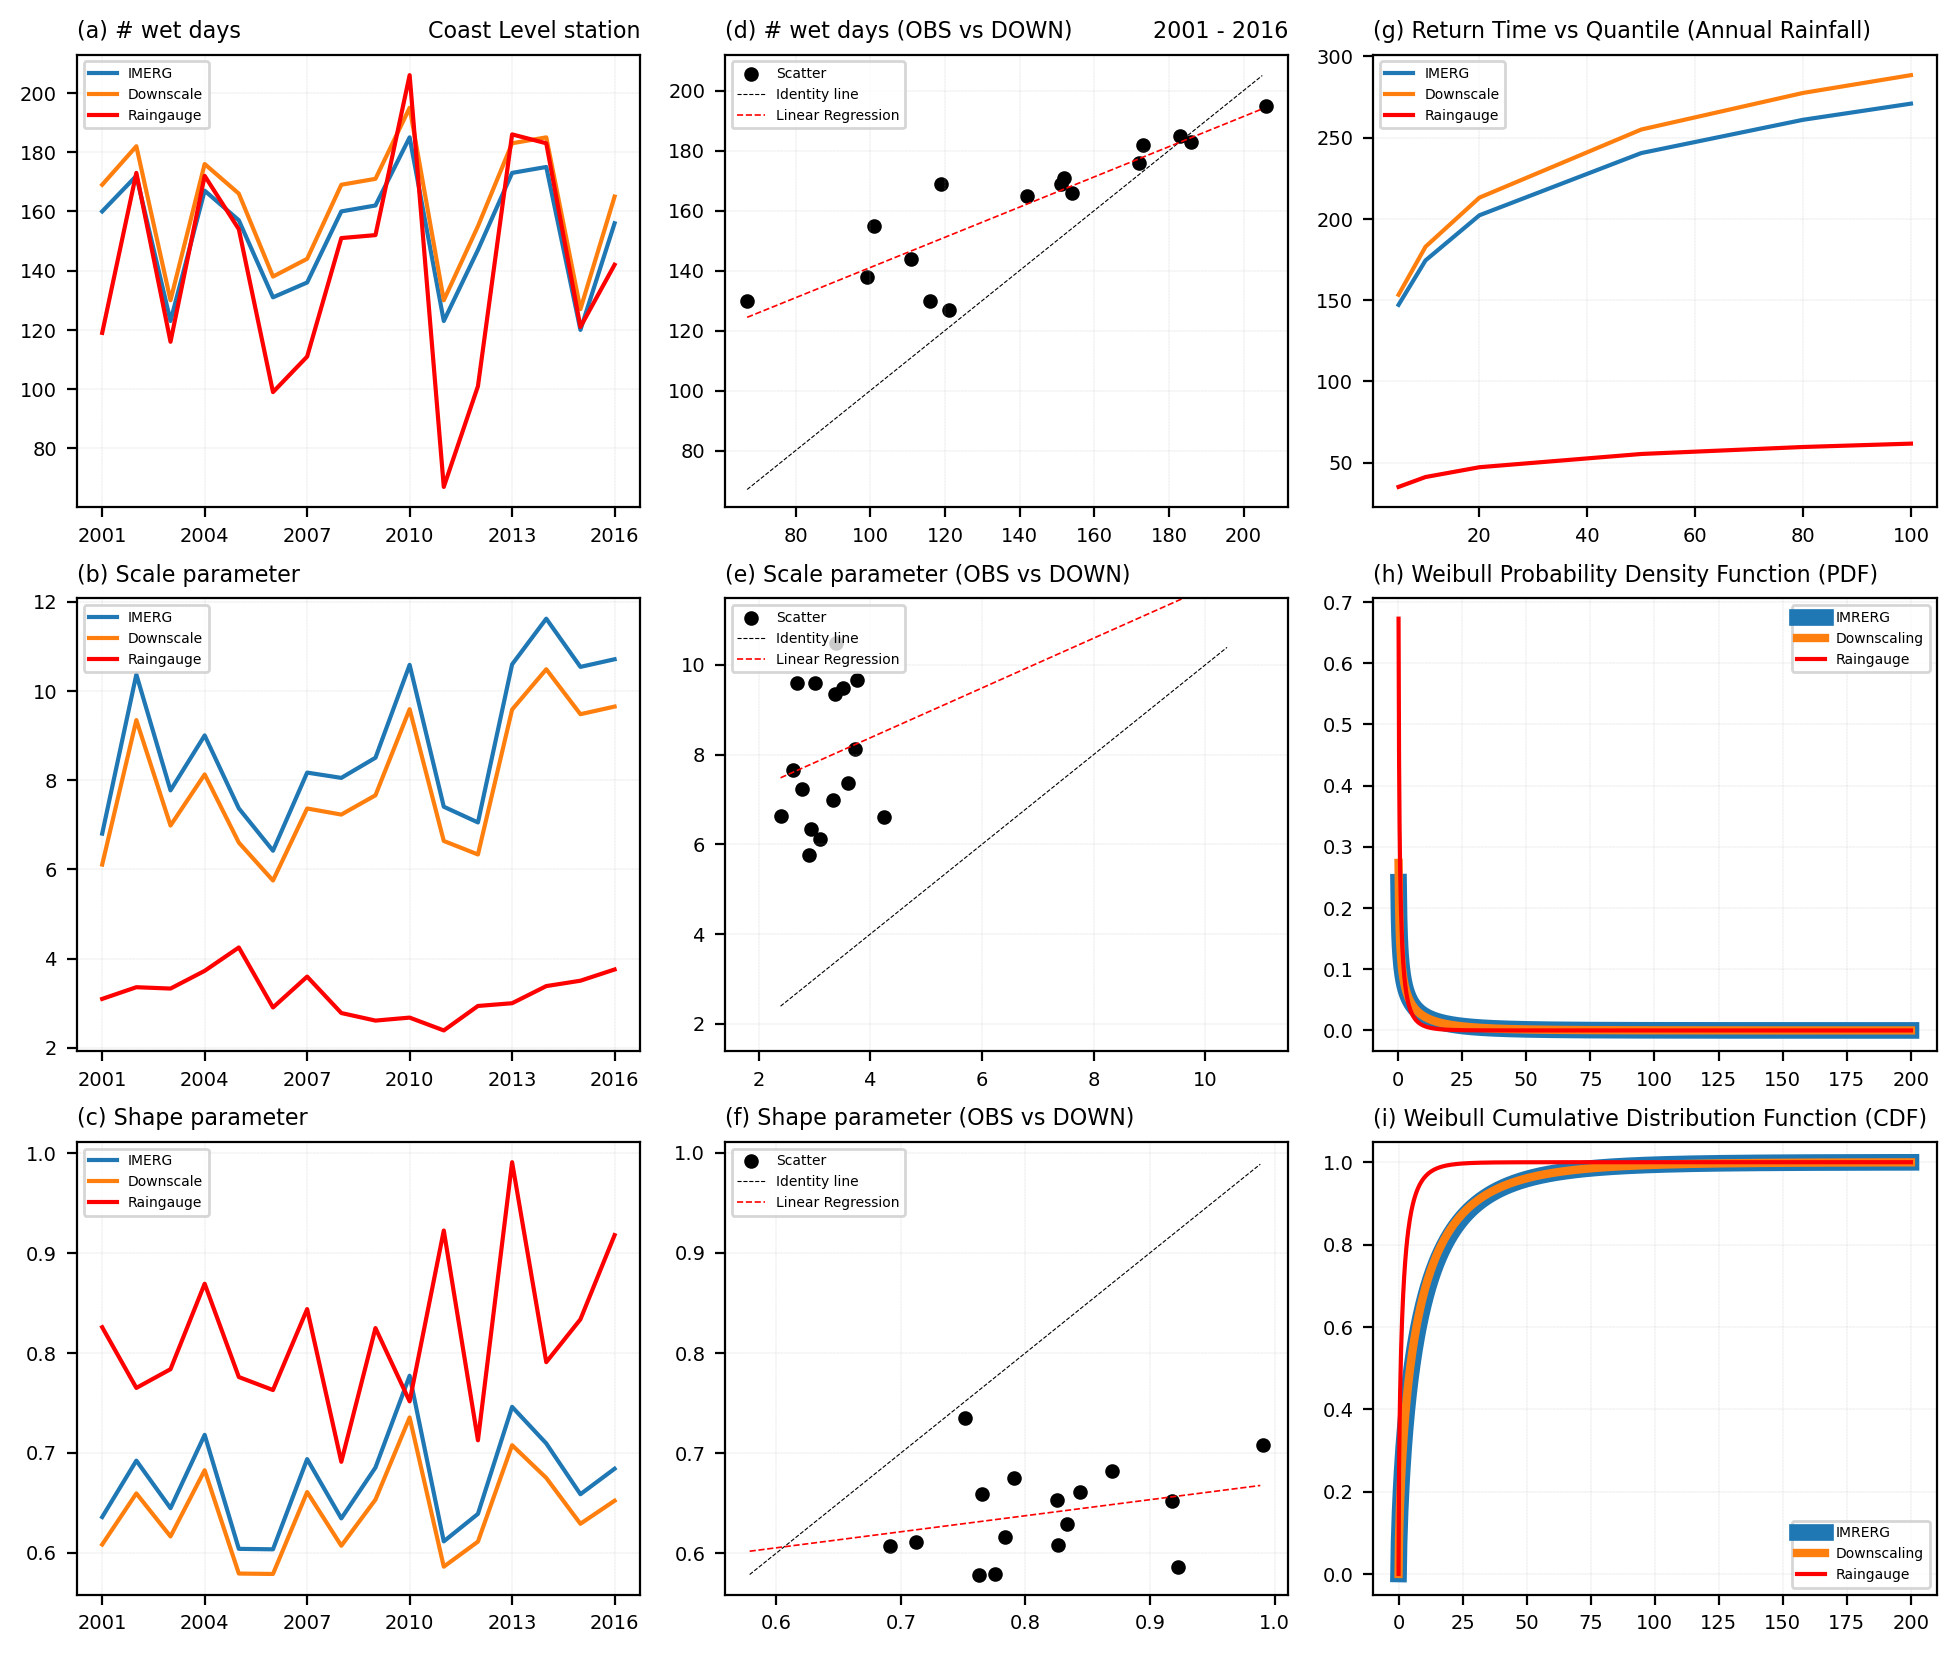

In [121]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,10),dpi=200)
gs = gridspec.GridSpec(3,3)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(YEARS, downres['NYs'], label='IMERG')
ax1.plot(YEARS, downres['NYd'], label='Downscale')
ax1.plot(YEARS, NCW[:,0], c='r', label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(a) # wet days', loc='left', fontsize=8)
ax1.set_title(f'{name} station', loc='right', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.plot(YEARS, downres['CYs'], label='IMERG')
ax1.plot(YEARS, downres['CYd'], label='Downscale')
ax1.plot(YEARS, NCW[:,1], c='r', label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[2, 0])

ax1.plot(YEARS, downres['WYs'], label='IMERG')
ax1.plot(YEARS, downres['WYd'], label='Downscale')
ax1.plot(YEARS, NCW[:,2], c='r',label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(c) Shape parameter', loc='left', fontsize=8)

# ============================================================================================================================
# ============================================================================================================================
max_ref = np.max((np.max(NCW[:,0]), np.max(downres['NYd'])))
min_ref = np.min((np.min(NCW[:,0]), np.min(downres['NYd'])))
ax1 = plt.subplot(gs[0, 1])

ax1.scatter(NCW[:,0], downres['NYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW[:,0], downres['NYd'])
ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-6, max_ref+6)
ax1.set_ylim(min_ref-6, max_ref+6)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(d) # wet days (OBS vs DOWN)', loc='left', fontsize=8)
ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=8)

# ==============================================================================================
max_ref = np.max((np.max(NCW[:,1]), np.max(downres['CYd'])))
min_ref = np.min((np.min(NCW[:,1]), np.min(downres['CYd'])))
ax1 = plt.subplot(gs[1, 1])

ax1.scatter(NCW[:,1], downres['CYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW[:,1], downres['CYd'])
ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-1, max_ref+1)
ax1.set_ylim(min_ref-1, max_ref+1)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(e) Scale parameter (OBS vs DOWN)', loc='left', fontsize=8)

# ==============================================================================================
max_ref = np.max((np.max(NCW[:,2]), np.max(downres['WYd'])))
min_ref = np.min((np.min(NCW[:,2]), np.min(downres['WYd'])))
ax1 = plt.subplot(gs[2, 1])

ax1.scatter(NCW[:,2], downres['WYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref, 0.01),np.arange(min_ref,max_ref, 0.01), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW[:,2], downres['WYd'])
ax1.plot(np.arange(min_ref,max_ref, 0.01), slope*np.arange(min_ref,max_ref, 0.01) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-0.02, max_ref+0.02)
ax1.set_ylim(min_ref-0.02, max_ref+0.02)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(f) Shape parameter (OBS vs DOWN)', loc='left', fontsize=8)

# ============================================================================================================================
# ============================================================================================================================
quant, flags = down.mev_quant(Fi, 0, NCW[:,0], NCW[:,1], NCW[:,2], thresh=1)
ax1 = plt.subplot(gs[0, 2])
ax1.plot(Tr, downres['mev_s'], label='IMERG')
ax1.plot(Tr, downres['mev_d'], label='Downscale')
ax1.plot(Tr, quant, c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(g) Return Time vs Quantile (Annual Rainfall)', loc='left', fontsize=8)

# ==============================================================================================
x = np.linspace(0, 200, 1000)
OBS_N, OBS_scale, OBS_shape = down.wei_fit(OBS.data)
OBS_pdf = weibull_min.pdf(x, OBS_shape, scale=OBS_scale)
IMERG_pdf = weibull_min.pdf(x, downres['Ws'], scale=downres['Cs'])
DOWN_pdf = weibull_min.pdf(x, downres['Wd'], scale=downres['Cd'])
ax1 = plt.subplot(gs[1, 2])
ax1.plot(x, IMERG_pdf, linewidth=6, label='IMRERG')
ax1.plot(x, DOWN_pdf, linewidth=3, label='Downscaling')
ax1.plot(x, OBS_pdf,  c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=0)
ax1.set_title('(h) Weibull Probability Density Function (PDF)', loc='left', fontsize=8)

# ==============================================================================================
x = np.linspace(0, 200, 1000)
OBS_cdf = weibull_min.cdf(x, OBS_shape, scale=OBS_scale)
IMERG_cdf = weibull_min.cdf(x, downres['Ws'], scale=downres['Cs'])
DOWN_cdf = weibull_min.cdf(x, downres['Wd'], scale=downres['Cd'])
ax1 = plt.subplot(gs[2, 2])
ax1.plot(x, IMERG_cdf, linewidth=6, label='IMRERG')
ax1.plot(x, DOWN_cdf, linewidth=3, label='Downscaling')
ax1.plot(x, OBS_cdf,  c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=0)
ax1.set_title('(i) Weibull Cumulative Distribution Function (CDF)', loc='left', fontsize=8)
# ============================================================================================================================
# ============================================================================================================================
plt.subplots_adjust(hspace=0.2,wspace=0.15)

# salida = os.path.join('..','fig',f'Weibull_parameters_{name.replace(' ','_')}_station.png')
# print(f'Export figure to: {salida}')
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)